# Step 1: Importing the libraries

In [237]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.14.0'

# Step 2: Importing the model with pre-trained weights

In [238]:
base_model = tf.keras.applications.InceptionV3(include_top = False,
                                                weights = 'imagenet')

In [239]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_470 (Conv2D)         (None, None, None, 32)       864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_470 (B  (None, None, None, 32)       96        ['conv2d_470[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_470 (Activation  (None, None, None, 32)       0         ['batch_normalizati

# Note:
- The objective of the algorithm is to select a layer to maximize the loss function, which are the activations
- We can select any layer, remembering that the first layers have simpler characteristics (edges) and higher layers have more complex and detailed characteristics of the objects
- The Inception network has multiple concatenated layers called 'mixed'

In [240]:
# names = ['mixed8', 'mixed9']
#names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']
names = ['mixed3', 'mixed5']
# names = ['mixed5']

In [241]:
layers = [base_model.get_layer(name).output for name in names]

In [242]:
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [243]:
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

# Step 3: Process an image

In [244]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/StaryNight.jpg',
                                                     target_size = (225, 375))

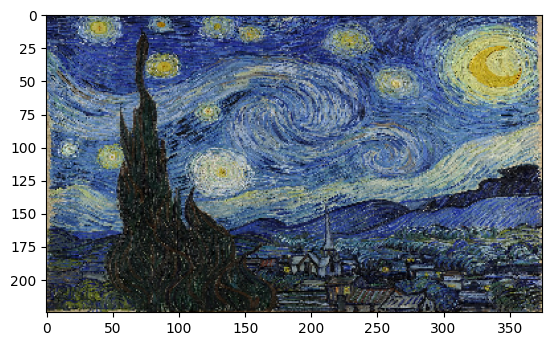

In [245]:
plt.imshow(sample_image)

In [246]:
type(sample_image)

PIL.Image.Image

In [247]:
sample_image = np.array(sample_image) / 255.0
sample_image.shape

(225, 375, 3)

In [248]:
type(sample_image)

numpy.ndarray

In [249]:
sample_image.max()

1.0

In [250]:
sample_image.min()

0.0

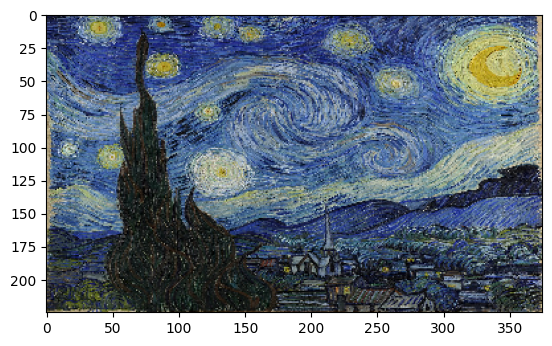

In [251]:
plt.imshow(sample_image)

# Step 4: Run the pre-trained model and explore activations

In [252]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image.shape

(225, 375, 3)

In [253]:
type(sample_image)

numpy.ndarray

In [254]:
sample_image = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_image))

In [255]:
type(sample_image)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [256]:
sample_image = tf.expand_dims(sample_image, axis = 0)
np.shape(sample_image)

TensorShape([1, 225, 375, 3])

In [257]:
np.shape(sample_image)

TensorShape([1, 225, 375, 3])

In [258]:
activations = deepdream_model(sample_image)

In [259]:
len(activations)

2

In [260]:
activations[1]

<tf.Tensor: shape=(1, 12, 21, 768), dtype=float32, numpy=
array([[[[3.3564959 , 4.192068  , 3.956008  , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 3.291921  , ..., 0.        ,
          0.        , 0.        ],
         [1.1941631 , 2.856439  , 0.96716774, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.04352278, 1.3129805 , 1.013164  , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 2.0410585 , ..., 0.        ,
          0.        , 0.04438502],
         [1.5365858 , 1.8807362 , 1.8185143 , ..., 0.        ,
          0.        , 0.19884157]],

        [[1.1933165 , 2.149592  , 2.3402357 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 4.6455283 , ..., 0.        ,
          0.        , 0.        ],
         [0.21899474, 1.6884648 , 0.23547879, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.452485

In [261]:
activations

[<tf.Tensor: shape=(1, 12, 21, 768), dtype=float32, numpy=
 array([[[[0.        , 0.6236413 , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.63640016, 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.02043545, 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
 
         [[0.        , 0.00481814, 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.1344443 , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
        

# Step 5: Loss calculation

- We will calculate the loss that represents the sum of the activations of a specific layer
- Most of the time the objective is to minimize the error (loss) using gradient descent, however, in deep dream the objective is to maximize the loss
- This is done using gradient ascent
- The function routes the image through the neural network and generates activations. Then we obtain the sum of the outputs

In [262]:
def calc_loss(image, model, test=1):
    if test == 1:
        img_batch = tf.expand_dims(image, axis=0)
        layer_activations = model(img_batch)
    else:
        layer_activations = model(image)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    print('Losses from multiple activation layers = ', losses)
    print('Losses shape = ', tf.shape(losses))
    print('Sum of all losses = ', tf.reduce_sum(losses))

    return tf.reduce_sum(losses)


In [263]:
loss = calc_loss(sample_image, deepdream_model, test = 0)
loss

Losses from multiple activation layers =  [<tf.Tensor: shape=(), dtype=float32, numpy=0.26344284>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17727819>]
Losses shape =  tf.Tensor([2], shape=(1,), dtype=int32)
Sum of all losses =  tf.Tensor(0.44072104, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.44072104>

# Step 6: Gradient Rising

- Let's use the loss calculated in the previous step and calculate the gradient with respect to the input image. Then we add the values ​​to the input image

In [264]:
@tf.function
def deepdream(model, image, step_size):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = calc_loss(image, model)

  gradients = tape.gradient(loss, image)
  gradients /= tf.math.reduce_std(gradients)
  image = image + gradients * step_size
  image = tf.clip_by_value(image, -1, 1)

  return loss, image

In [265]:
def run_deep_dream_simple(model, image, steps = 100, step_size = 0.01):
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  for step in range(steps):
    loss, image = deepdream(model, image, step_size)

    if step % 100 == 0:
      plt.figure(figsize=(12,12))
      plt.imshow(deprocess(image))
      plt.show()
      print('Step {}, loss {}'.format(step, loss))

  plt.figure(figsize=(12,12))
  plt.imshow(deprocess(image))
  plt.show()

  return deprocess(image)


In [266]:
def deprocess(image):
  image = 255 * (image + 1.0) / 2.0
  return tf.cast(image, tf.uint8)


# Step 7: First Test

In [267]:
test_image = tf.keras.preprocessing.image.load_img(r'/content/StaryNight.jpg',
                                                     target_size = (225, 375))
test_image = np.array(test_image)

In [268]:
np.shape(test_image)

(225, 375, 3)

In [ ]:
dream_img = run_deep_dream_simple(model = deepdream_model,
                                  image = test_image,
                                  steps = 2000, step_size = 0.001)